In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from IPython.display import display

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.8.0.dev20250409+cu128
Torchvision version 0.22.0.dev20250410+cu128
Numpy version 1.26.4
Pandas version 2.2.3


In [2]:
pip install timm

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
class SharkDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
data_home_dir = 'archive/'
dataset_path = data_home_dir + 'sharks'
dataset = SharkDataset(
    data_dir = dataset_path 
)

In [4]:
len(dataset)

1546

9


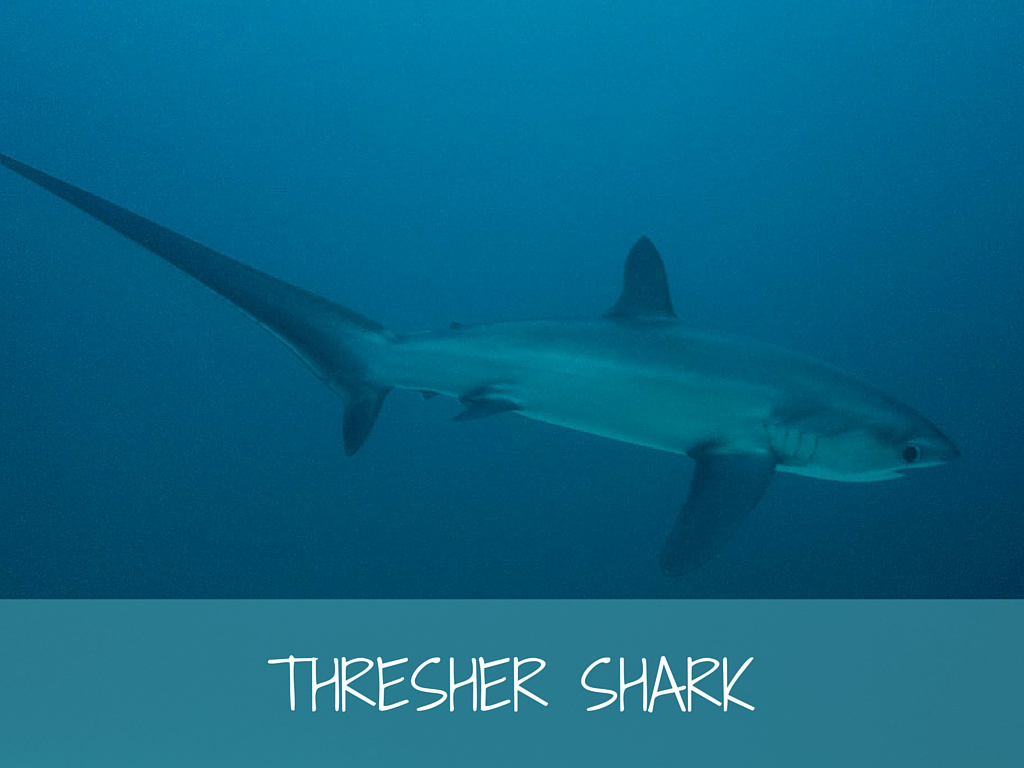

In [5]:
image, label = dataset[1000]
print(label)
image

In [6]:
target_to_class = {v: k for k, v in ImageFolder(dataset_path).class_to_idx.items()}
print(target_to_class)

{0: 'basking', 1: 'blacktip', 2: 'blue', 3: 'bull', 4: 'hammerhead', 5: 'lemon', 6: 'mako', 7: 'nurse', 8: 'sand tiger', 9: 'thresher', 10: 'tiger', 11: 'whale', 12: 'white', 13: 'whitetip'}


In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = SharkDataset(dataset_path, transform)

In [8]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [9]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in dataloader:
    break

In [11]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [12]:
labels

tensor([ 2, 10, 13, 11,  2,  1, 13,  8,  5,  6,  8, 12, 12,  5, 12, 12, 10, 10,
         2,  8,  9,  0,  6, 12, 11,  1,  3,  2, 11,  9, 11,  4])

In [13]:
class SharkClassifier(nn.Module):
    def __init__(self, num_classes=14):
        super(SharkClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [14]:
model = SharkClassifier(num_classes=14)
print(str(model)[:500])

SharkClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)



In [15]:
example_out = model(images)
example_out.shape

torch.Size([32, 14])

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 14]) torch.Size([32])


In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = data_home_dir + 'sharks/'
valid_folder = train_folder
test_folder = train_folder

train_dataset = SharkDataset(train_folder, transform=transform)
val_dataset = SharkDataset(valid_folder, transform=transform)
test_dataset = SharkDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Simple training loop
num_epochs = 1
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SharkClassifier(num_classes=14)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/49 [00:00<?, ?it/s]

c:\Users\timur\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loop:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 1.646728873715518, Validation loss: 0.6997741180511835


: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Training loss')
ax.plot(val_losses, label='Validation loss')
ax.legend()
ax.set_title("Loss over epochs")
display(fig)
plt.close(fig)

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization without matplotlib figures
def show_prediction(original_image, probabilities, class_names, top_k=5):
    preview = original_image.copy()
    preview.thumbnail((256, 256))
    display(preview)

    df = (pd.DataFrame({
        "class": class_names,
        "probability": probabilities
    })
    .sort_values("probability", ascending=False)
    .reset_index(drop=True))
    display(df.head(top_k))

# Example usage
test_image = "/kaggle/input/shark-species/sharks/blacktip/00000001.jpg"
# test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
show_prediction(original_image, probabilities, class_names)

In [ ]:
from glob import glob
test_images = glob(data_home_dir + '*/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    show_prediction(original_image, probabilities, class_names)

In [ ]:
test_images